<h1>Stack Overflow Survey Analysis<h1>

In [ ]:
%matplotlib inline
import json
import country_converter as coco
from datetime import datetime, timedelta
import requests
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from tabulate import tabulate

<h3>First we loaded the survey data into Pandas dataframe to perform the analysis</h3>

<h4>Read survey data file </h4>

In [2]:
survey_df = pd.read_csv('/home/jovyan/demo/Stack_overflow/survey_results_public.csv',low_memory=False,delimiter=',')
survey_df.head()

<h3>Data Understanding and Finding % of Missing Values</h3>

In [4]:
def missing_data_summary(survey_df):
    return pd.DataFrame({
                        'column_name'  : survey_df.columns,
                        'missing_rows' : list(survey_df.isna().sum()),
                        'missing_%'    : list((survey_df.isna().sum()/survey_df.shape[0])* 100)
    }
    )\
    .sort_values(by = 'missing_rows' , ascending = False)\
    .reset_index(drop = True)\
    .style\
    .set_caption(f'Total Rows: {survey_df.shape[0]}')\
    .background_gradient(cmap = 'viridis')


missing_data_summary(survey_df)

<h3> 1) Data Cleansing </h3>

<h4>
Since the data has so many null values we needed to use a function either to remove the nulls ( which will result in much less data, hence less accuracy)
Or use a function that fills NA/NaN values using the specified method (forward or backward)
</h4>

In [6]:
survey_df.fillna(method='ffill')
survey_df.fillna(method='bfill')

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,113750.0,37500.0
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,113750.0,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,70000.0
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,100000.0,70000.0
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,Disagree,Male,A bachelor's degree,White or of European descent,Disagree,Agree,Disagree,Agree,100000.0,70000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51387,51388,Professional developer,"Yes, I program as a hobby",United States,No,Employed full-time,Bachelor's degree,A social science,A few days each month,100 to 499 employees,...,Disagree,Male,A doctoral degree,East Asian; White or of European descent,Disagree,Agree,Strongly disagree,Strongly agree,58000.0,NaN
51388,51389,Student,No,Venezuela,"Yes, full-time",Employed full-time,Master's degree,Computer programming or Web development,Never,100 to 499 employees,...,Disagree,Male,A master's degree,Black or of African descent; Hispanic or Latin...,Somewhat agree,Agree,Disagree,Agree,40000.0,NaN
51389,51390,Professional developer,"Yes, I program as a hobby",Canada,No,Employed full-time,Some college/university study without earning ...,"Information technology, networking, or system ...","Less than half the time, but at least one day ...",10 to 19 employees,...,Disagree,Male,A bachelor's degree,White or of European descent,Disagree,Agree,Disagree,Strongly agree,40000.0,NaN
51390,51391,Professional developer,"Yes, I program as a hobby",United States,No,Employed full-time,Bachelor's degree,Computer science or software engineering,Never,Fewer than 10 employees,...,Disagree,Male,A bachelor's degree,White or of European descent,Disagree,Agree,Disagree,Strongly agree,40000.0,NaN


<h3> 2)Dataset Scope </h3>


<h4> Here we select the columns that we will use for the analysis and place them in a dataframe.     
We also select specific genders to get more accurate and generalized data ( Males & Females) </h4> 

In [7]:
NW_df = survey_df.loc[:,['Respondent','Country','Salary','JobSatisfaction','Gender']]
Gender= ['Male','Female']
NW_df= NW_df[NW_df.Gender.isin(Gender)]

<h4> We select the top 10 countries which have the highest response rate </h4> 

In [8]:
#Top 10 Respondent countries
NW_df_Groupby = NW_df.groupby(by=["Country"]).count()

Top_10_countries_NW_df = NW_df_Groupby.sort_values(['Respondent','Country'], ascending=False).head(10)

Top_10_countries_NW_df = Top_10_countries_NW_df.reset_index()  # Country & b are now back out of the index, as a normal columns.
Top_10_countries_NW_df.rename(columns={"index": "Respondent"})
Top_10_countries_NW_df = Top_10_countries_NW_df.loc[:,['Respondent','Country']]

Top_10_countries_NW_df.head(10)

,Respondent,Country
0,8294,United States
1,3175,United Kingdom
2,2893,Germany
3,2652,India
4,1596,Canada
5,1158,France
6,904,Poland
7,674,Australia
8,627,Netherlands
9,573,Russian Federation


In [9]:
# Setting the path to the shapefile
SHAPEFILE = '/home/jovyan/demo/Countries/ne_10m_admin_0_countries.shp'

# Read shapefile using Geopandas
geo_df = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]

# Rename columns.
geo_df.columns = ['country', 'country_code', 'geometry']
geo_df.head()


# Drop row for 'Antarctica'. It takes a lot of space in the map and is not of much use
geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)

# Next, we need to ensure that our data matches with the country codes. 
iso3_codes = geo_df['country'].to_list()

# Convert to iso3_codes
iso2_codes_list = coco.convert(names=iso3_codes, to='ISO2', not_found='NULL')

# Add the list with iso2 codes to the dataframe
geo_df['iso2_code'] = iso2_codes_list

# There are some countries for which the converter could not find a country code. 
# We will drop these countries.
geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)

geo_df = geo_df.rename(columns={'country': 'Country'})

Dhekelia Sovereign Base Area not found in regex
US Naval Base Guantanamo Bay not found in regex
Siachen Glacier not found in regex
Baykonur Cosmodrome not found in regex
Akrotiri Sovereign Base Area not found in regex
Southern Patagonian Ice Field not found in regex
Bir Tawil not found in regex
Indian Ocean Territories not found in regex
Coral Sea Islands not found in regex
Spratly Islands not found in regex
Clipperton Island not found in regex
Ashmore and Cartier Islands not found in regex
Bajo Nuevo Bank (Petrel Is.) not found in regex
Serranilla Bank not found in regex
Scarborough Reef not found in regex


In [10]:
Top_10_countries = Top_10_countries_NW_df.sort_values(['Respondent','Country'], ascending=False).head(10)

Top_10_countries = Top_10_countries.reset_index()  # Country & b are now back out of the index, as a normal columns.
Top_10_countries.rename(columns={"index": "Country"})
Top_10_countries = Top_10_countries.loc[:,['Respondent','Country']]

# some Counrties have differente naming convention in the geo mapping file.
Top_10_countries['Country'] = Top_10_countries['Country'].str.replace("United States","United States of America")  
Top_10_countries['Country'] = Top_10_countries['Country'].str.replace("Russian Federation","Russia")  # Normal indexing works.

merged_df = pd.merge(geo_df, Top_10_countries, on= "Country")
merged_df.head(10)

,Country,country_code,geometry,iso2_code,Respondent
0,India,IND,"MULTIPOLYGON (((77.80035 35.49541, 77.81533 35...",IN,2652
1,France,FRA,"MULTIPOLYGON (((-54.11153 2.11427, -54.13491 2...",FR,1158
2,Russia,RUS,"MULTIPOLYGON (((87.81632 49.16584, 87.71638 49...",RU,573
3,Germany,DEU,"MULTIPOLYGON (((13.81572 48.76643, 13.78586 48...",DE,2893
4,Poland,POL,"POLYGON ((18.83320 49.51026, 18.83743 49.52695...",PL,904
5,United Kingdom,GBR,"MULTIPOLYGON (((-7.24710 55.06932, -7.25674 55...",GB,3175
6,Netherlands,NLD,"MULTIPOLYGON (((7.19459 53.24502, 7.19747 53.2...",NL,627
7,United States of America,USA,"MULTIPOLYGON (((-95.16057 49.36949, -95.10282 ...",US,8294
8,Canada,CAN,"MULTIPOLYGON (((-99.79271 67.80492, -99.79528 ...",CA,1596
9,Australia,AUS,"MULTIPOLYGON (((131.53590 -31.60556, 131.34555...",AU,674


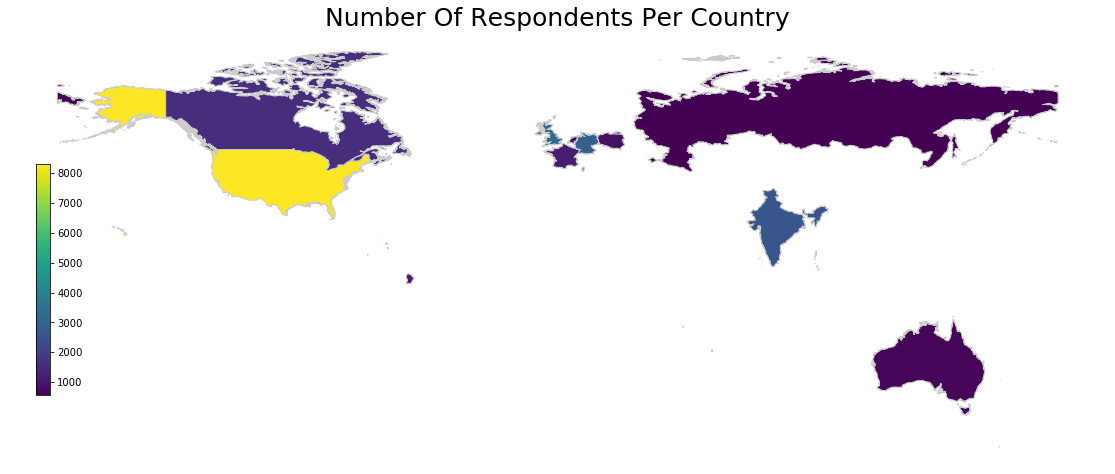

In [11]:
# Print the map
# Set the range for the choropleth
title = 'Number Of Respondents Per Country'
col = 'Respondent'
source = ''
vmin = merged_df[col].min()
vmax = merged_df[col].max()
cmap = 'viridis'

# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 8))

# Remove the axis
ax.axis('off')
merged_df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)


# Add a title
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})

# Create an annotation for the data source
ax.annotate(source, xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', 
            verticalalignment='bottom', fontsize=10)
            
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

# Empty array for the data range
sm._A = []

# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)

<h4> We create another dataframe which merges the full dataframe with the top 10 countries only. </h4>

In [12]:
m = NW_df.Country.isin(Top_10_countries_NW_df.Country)
NW_df = NW_df[m]

NW_df

,Respondent,Country,Salary,JobSatisfaction,Gender
0,1,United States,NaN,NaN,Male
1,2,United Kingdom,NaN,NaN,Male
2,3,United Kingdom,113750.000000,9.0,Male
3,4,United States,NaN,3.0,Male
6,7,United States,NaN,6.0,Male
...,...,...,...,...,...
51382,51383,France,32258.064516,5.0,Male
51384,51385,United States,NaN,5.0,Male
51385,51386,United Kingdom,NaN,7.0,Female
51387,51388,United States,58000.000000,3.0,Male


<h4> Then we calculate the average salary per country </h4>

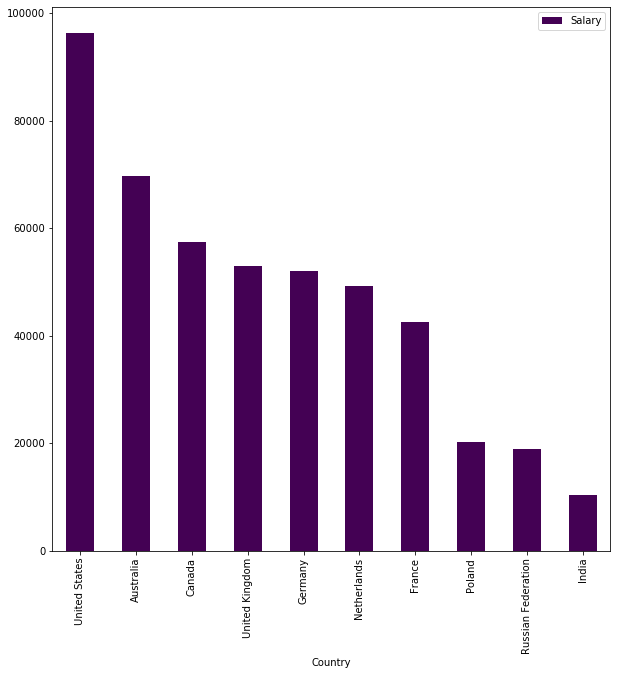

In [13]:
avg_salary = NW_df.groupby(by=["Country"])['Salary'].mean()
avg_salary = avg_salary.reset_index()  # Country & b are now back out of the index, as a normal columns.
avg_salary.rename(columns={"index": "Country"})
sorted_avg_salary_per_country = avg_salary.sort_values(['Salary'], ascending=False)


sorted_avg_salary_per_country.plot(x ='Country', y= 'Salary',colormap ='viridis',kind="bar",figsize = (10,10))
plt.savefig('Country')

<h3> Conclusion: </h3>

<h4> From the above result, we notice that the top three highest average-salary countries are: United States, Australia, Canada </h4>

<h3> Q2 which country has the highest satisfaction rate? </h3>

<h4>This time we will focus on Job satisfaction in each country so we will use the corresponding columns which will answer the question </h4>

In [15]:
Sat_Per_Country = NW_df.loc[:,['Respondent','Country','JobSatisfaction']]
Sat_Per_Country = Sat_Per_Country.groupby(by=['Country','JobSatisfaction']).count()
Sat_Per_Country.head(110)

Respondent
Country       JobSatisfaction            
Australia     0.0                       7
              1.0                       4
              2.0                      13
              3.0                      35
              4.0                      30
...                                   ...
United States 6.0                     767
              7.0                    1286
              8.0                    1654
              9.0                    1233
              10.0                    811

[110 rows x 1 columns]

<h4> Here we calculate the highest job satisfaction rate per response count </h4>

In [16]:
Sat_Per_Country = Sat_Per_Country.reset_index() 
Sat_Per_Country.rename(columns={"index": "Country"})

Sat_Per_Country = Sat_Per_Country.sort_values(['Respondent'], ascending=False).groupby(Sat_Per_Country['Country']).head(1)
Sat_Per_Country

,Country,JobSatisfaction,Respondent
107,United States,8.0,1654
96,United Kingdom,8.0,665
41,Germany,8.0,536
51,India,7.0,360
19,Canada,8.0,337
30,France,8.0,212
74,Poland,8.0,186
63,Netherlands,8.0,162
8,Australia,8.0,138
85,Russian Federation,8.0,106


<h3> Conclusion </h3>

<h4> From the above result, we can conclude that the top three countries which have the highest satisfaction rate are : United States, United Kingdom, Germany </h4>

<h3> Q3. Which country is most suited for females to work in? </h3>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fec3acf47d0>],
      dtype=object)

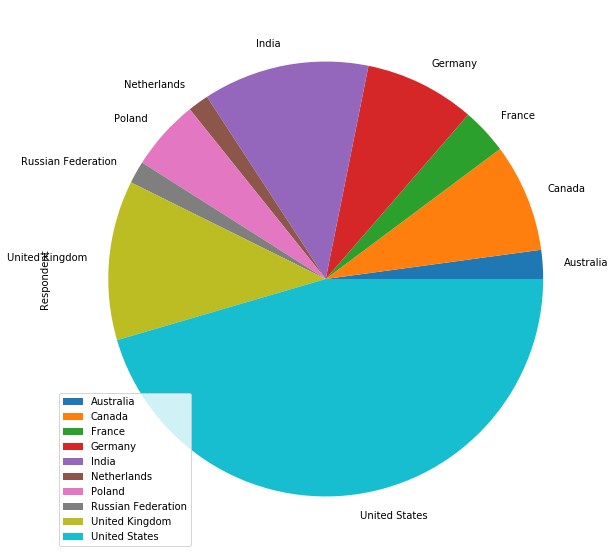

In [18]:
#We will filter only Females from the Gender columns to answer this question

Gender= ['Female']
NW_df_Female= NW_df[NW_df.Gender.isin(Gender)]

#Then we will select the suitable columns and count each gender in each country

Gender_Per_Country = NW_df_Female.loc[:,['Respondent','Country']]
Gender_Per_Country = Gender_Per_Country.groupby(by=['Country']).count()

#Then we wil find the highest response rate from females in each country

Gender_Per_Country_2 = Gender_Per_Country
Gender_Per_Country = Gender_Per_Country.reset_index() 
Gender_Per_Country.rename(columns={"index": "Country"})

Gender_Per_Country = Gender_Per_Country.sort_values(['Respondent'], ascending=False).groupby(Gender_Per_Country['Country']).head(1)

Gender_Per_Country_2.plot(kind ="pie",subplots = True,figsize = (10,10))

<h3> Conclusion </h3>

<h4> Fom the above result, we can conclude that the top three countries: (United States, India, United Kingdom) have the highest response rate from females 
which might indicate that these countries are better suited for females to work in </h4>